In [1]:
# Importing dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# To find the most recent date we need to know in which table is the date column
# To inspect database table names
inspector = inspect(engine)

# First Station table 
station_columns = inspector.get_columns("station")
for column in station_columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Next Measurement table 
measurement_columns = inspector.get_columns("measurement")
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.
# The date column is in the measurement table.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)

('2017-08-23',)


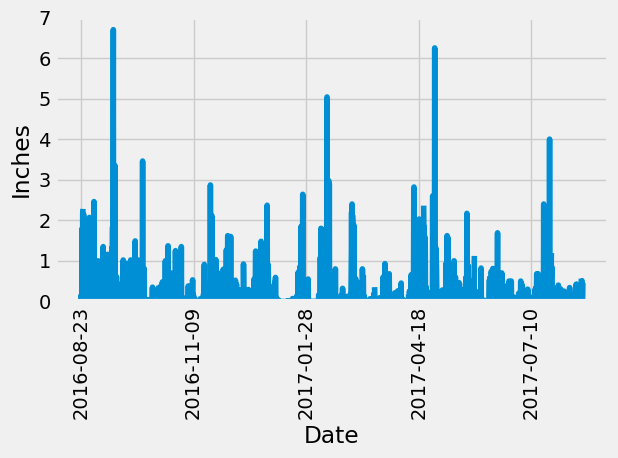

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
values = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
values_df = pd.DataFrame(values, columns=["date", "prcp"]).set_index("date")

# Sort the dataframe by date
values_df.plot(legend=False)
plt.ylim(0, 7)
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.tight_layout()

# Use Pandas Plotting with Matplotlib to plot the data
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
values_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_number_stations = session.query(Station.station).count()
print(total_number_stations)

9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

active_stations_list = [(station, count) for station, count in active_stations]
print(active_stations_list)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Getting the most active station id from the previous query
most_active_station_id = active_stations[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')).filter(Measurement.station == most_active_station_id).all()

# Print the results
min_temp, max_temp, avg_temp = temperature_stats[0]
print(min_temp, max_temp, avg_temp)

54.0 85.0 71.66378066378067


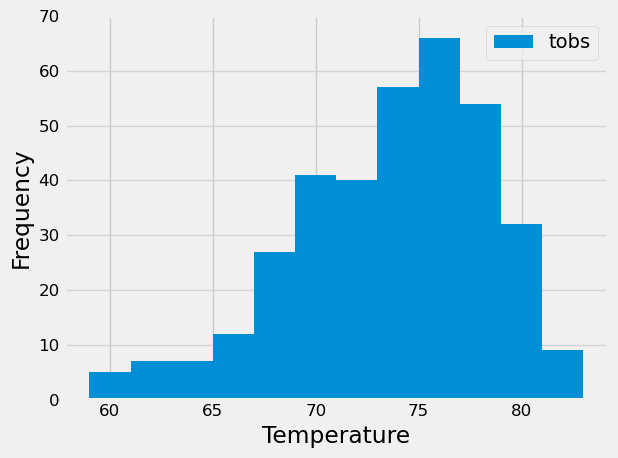

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Find most recent date for Station: USC00519281 in the Measurement table
most_active_station_id = active_stations[0][0]

# Then Find the most recent date for the most active station in the Measurement table
most_recent_date_station = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    order_by(Measurement.date.desc()).first()

# Create query to find the 12 months before the most recent date
one_year_ago = (pd.to_datetime(most_recent_date_station[0]) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Retrieve the last 12 months of temperature for this station
twelve_month_values = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Create a DataFrame with just tobs from this 12-month period
twelve_month_tobs_values_df = pd.DataFrame(twelve_month_values)["tobs"]

# Now Plot the histogram
plt.hist = twelve_month_tobs_values_df.hist(bins=12, density=False, label='tobs')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 70)
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

# Close Session

In [22]:
# Close Session
session.close()